In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns

root_dir = '/Users/leaf/SpringBoard/Capstone'
base_skin_dir = root_dir + '/data/Kaggle_HAM10000'

In [2]:
# Build a dictionary with image id and path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Create a dictionary of abbreviations
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Initialize our main dataframe 
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3544,HAM_0003470,ISIC_0025979,nv,follow_up,35.0,female,lower extremity,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Melanocytic nevi,4
4575,HAM_0003111,ISIC_0030495,nv,follow_up,45.0,female,lower extremity,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Melanocytic nevi,4
5786,HAM_0003270,ISIC_0025764,nv,follow_up,35.0,male,back,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Melanocytic nevi,4


In [4]:
# Clean data
tile_df = tile_df[tile_df['sex'] != 'unknown']
tile_df = tile_df[tile_df['age'] != 0]
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

In [5]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2


In [6]:
# Load and resize images
from PIL import Image

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [7]:
tile_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/leaf/SpringBoard/Capstone/data/Kaggle_H...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."


In [8]:
tile_df['image'][0].shape

(75, 100, 3)

In [9]:
# Create dataframe to incorporate metadata into our classification
meta_df = tile_df.iloc[:,4:7]

In [10]:
meta_df['target'] = tile_df['cell_type_idx']
meta_df.head(3)

,age,sex,localization,target
0,80.0,male,scalp,2
1,80.0,male,scalp,2
2,80.0,male,scalp,2


In [11]:
meta_df['sex'] = meta_df['sex'].map(lambda x: 1 if x == 'male' else 0)

In [12]:
meta_df.head(3)

,age,sex,localization,target
0,80.0,1,scalp,2
1,80.0,1,scalp,2
2,80.0,1,scalp,2


In [13]:
meta_df['localization'].drop_duplicates()

0                 scalp
4                   ear
6                  face
8                  back
10                trunk
11                chest
16      upper extremity
29              abdomen
50              unknown
59      lower extremity
105             genital
164                neck
277                hand
431                foot
7410              acral
Name: localization, dtype: object

In [14]:
meta_df['localization'] = pd.Categorical(meta_df.localization)

In [15]:
meta_df['localization'] = pd.get_dummies(meta_df.localization)

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

X, y = meta_df.drop(['target'], axis=1), meta_df['target']

In [31]:
X.shape

(9921, 3)

In [33]:
y.shape

(9921,)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108)

In [35]:
X_train.shape

(7440, 3)

In [36]:
y_train.shape

(7440,)

In [37]:
import warnings
warnings.filterwarnings("ignore")

clf = LogisticRegressionCV(
            cv=5, 
            random_state=108, 
            multi_class='multinomial', 
            solver = 'lbfgs',
            max_iter = 200
    ).fit(X_train, y_train)

In [38]:
preds = clf.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

[[   0    0   11    0   71    0    0]
 [   0    0   26    0  103    0    0]
 [   0    0   54    0  217    0    0]
 [   0    0    1    0   28    0    0]
 [   0    0   28    0 1630    0    0]
 [   0    0   33    0  245    0    0]
 [   0    0    3    0   31    0    0]]


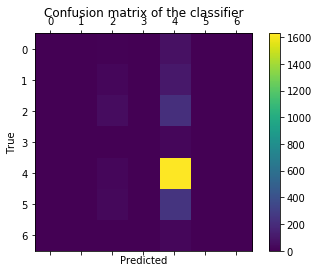

In [47]:
cm = confusion_matrix(y_test, preds)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

In [40]:
accuracy_score(y_test, preds)

0.6787585650947199

In [50]:
balanced_accuracy_score(y_test, preds)

0.16891059656762344

In [ ]:
# Random chance gives %14.28 so we have a slight improvement

In [ ]:
# Based on your age, sex and localization, what is the probability of having a cncerous lesion. Prior for Baysian?

In [ ]:
# Build plot for each sex, likelihood for cancerous lesion. 